In [1]:
import numpy as np 
import pandas as pd
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import gc
from collections import Counter

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
%%time
adata = sc.read_h5ad("02_scvi_adata.h5ad")
adata

CPU times: user 515 ms, sys: 7.98 s, total: 8.5 s
Wall time: 8.49 s


AnnData object with n_obs × n_vars = 60814 × 31846
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'tech_plus_study', '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'dendrogram_leiden_scVI', 'donor_id_colors', 'hvg', 'leiden_scVI', 'leiden_scVI_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'study_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

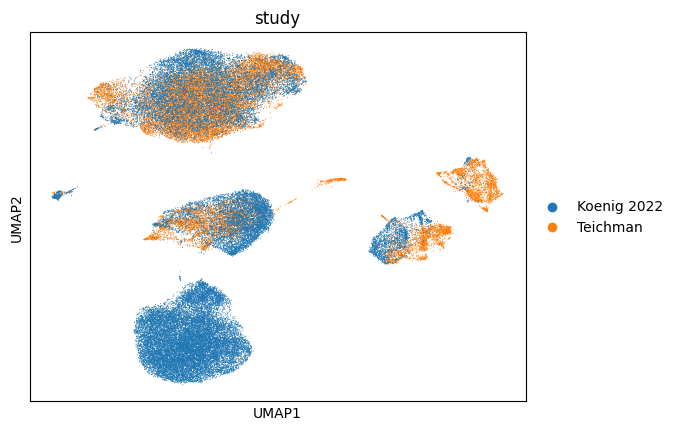

In [3]:
# check to see if there are good mixing of studies
sc.pl.umap(adata, color=["study"])

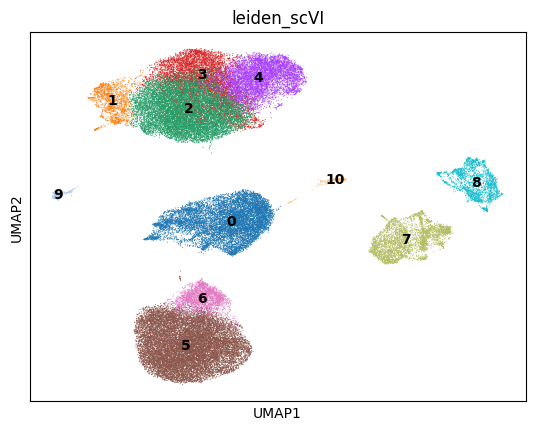

In [4]:
sc.pl.umap(adata, color=["leiden_scVI"], legend_loc = "on data")

### Examine the percentage of each leiden cluster per study

In [5]:
def produce_crosstab_barplot(metadata, cluster_label, metadata_column):
    '''Produce a barplot showing how the cluster_label (e.g. leiden) distributes according to a metadata column (e.g. study)'''

    prop_df = pd.crosstab(metadata[cluster_label], metadata[metadata_column])
    norm_prop_df = prop_df.div(prop_df.sum(axis = 1), axis = 0)

    ax = norm_prop_df.plot(kind = 'bar', stacked=True, figsize=(15, 5), colormap='tab20')
    ax.set_xlabel(cluster_label)
    ax.set_ylabel("Proportion")
    ax.set_title("Proportion per {cluster_label} grouped by {metadata_column}")

    # reverse the legend order so that it matches up with the barplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title={cluster_label}, bbox_to_anchor=(1.05, 1), loc='upper left')

    # rotate the x labels
    plt.xticks(rotation=90, ha='right')
    return plt

In [6]:
adata_metadata = adata.obs

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

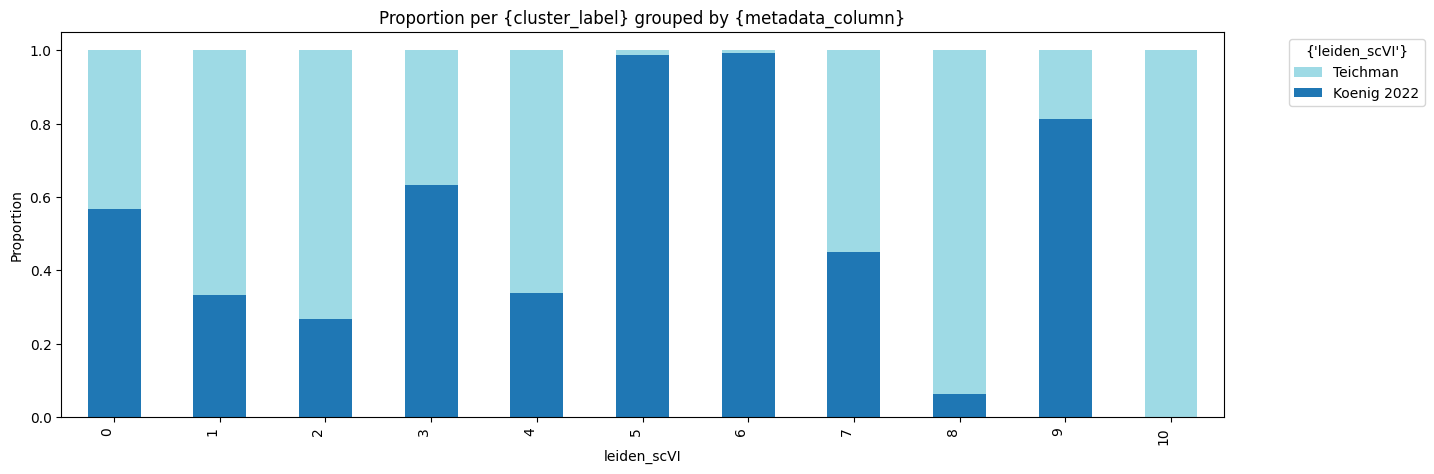

In [7]:
produce_crosstab_barplot(metadata = adata_metadata, cluster_label = 'leiden_scVI', metadata_column = 'study')

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

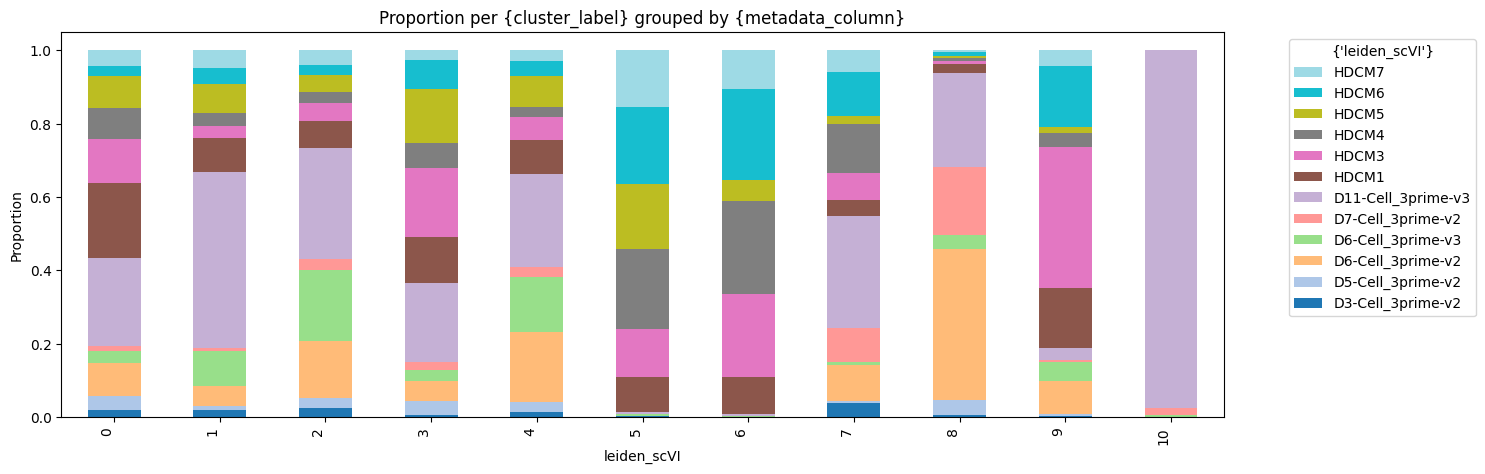

In [8]:
produce_crosstab_barplot(metadata = adata_metadata, cluster_label = 'leiden_scVI', metadata_column = 'donor_id')

### Annotate leiden clusters as cell types

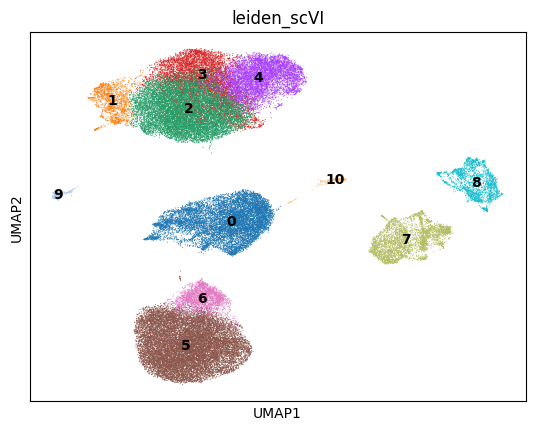

In [9]:
sc.pl.umap(adata, color = "leiden_scVI", legend_loc = "on data")

In [10]:
# run this to identify top marker genes per cluster
sc.get.rank_genes_groups_df(adata, group="7").head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,FTL,49.386742,3.334461,0.0,0.0
1,TYROBP,47.425472,6.834601,0.0,0.0
2,FCER1G,47.039799,6.788263,0.0,0.0
3,AIF1,46.811745,8.860808,0.0,0.0
4,LYZ,45.103470,8.601042,0.0,0.0
5,FTH1,43.911339,2.583940,0.0,0.0
6,SAT1,42.308666,3.490318,0.0,0.0
7,LAPTM5,41.041912,5.086452,0.0,0.0
8,CTSS,40.744186,5.522870,0.0,0.0
9,CYBA,39.451515,3.321549,0.0,0.0


In [11]:
adata.obs["scvi_cell_type"] = adata.obs["leiden_scVI"].map(
    {
        "0": "Pericyte",
        "1": "Endothelial",
        "2": "Endothelial",
        "3": "Endothelial",
        "4": "Endothelial",
        "5": "Fibroblast",
        "6": "Fibroblast",
        "7": "Myeloid",
        "8": "Lymphoid",
        "9": "Neuronal",
        "10": "Cardiomyocyte",
    }
)

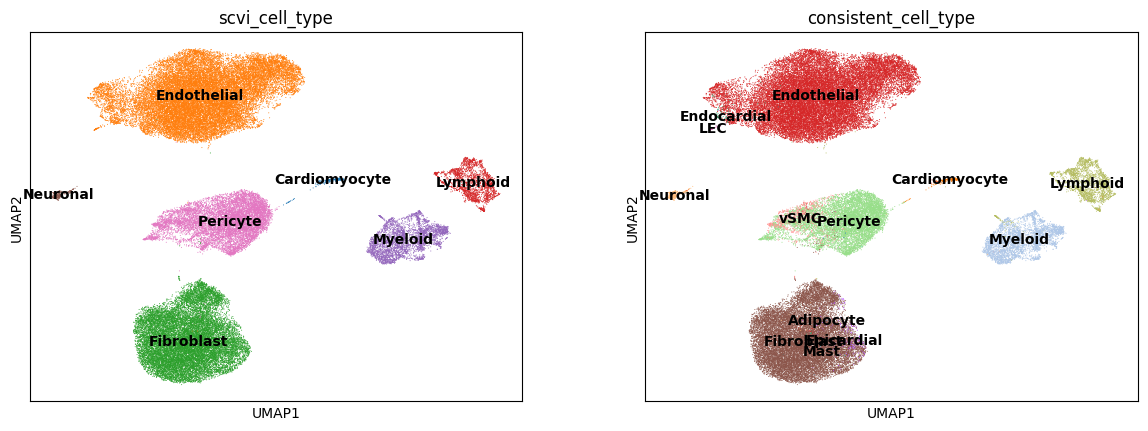

In [12]:
sc.pl.umap(adata, color=["scvi_cell_type", "consistent_cell_type"], legend_loc = "on data")

In [13]:
Counter(adata.obs.scvi_cell_type)

Counter({'Endothelial': 26214,
         'Fibroblast': 18303,
         'Pericyte': 9898,
         'Myeloid': 3812,
         'Lymphoid': 2065,
         'Neuronal': 272,
         'Cardiomyocyte': 250})

### Save the adata 

In [14]:
adata.write("03_scRNA_post_scvi.h5ad")

#### save version with scvi normalized layer

In [15]:
adata

AnnData object with n_obs × n_vars = 60814 × 31846
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'tech_plus_study', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'scvi_cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'dendrogram_leiden_scVI', 'donor_id_colors', 'hvg', 'leiden_scVI', 'leiden_scVI_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'study_colors', 'umap', 'scvi_cell_type_colors', 'consistent_cell_type_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [17]:
del adata.layers['scvi_normalized']

In [18]:
adata.write("03_scRNA_post_scvi_raw_counts_only.h5ad")